In [1]:
from mobslim.agents import ActivityType, Plan
from mobslim.expected import SimpleExpectedDurations
from mobslim.listener import EventListener
from mobslim.network import Grid
from mobslim.optimizer import Optimizer
from mobslim.planner import Planner, StaticRouter
from mobslim.sim import Sim

In [2]:
AGENTS = 10
SIZE = 4  # Size of the grid network
MAX_RUNS = 10  # Maximum number of runs for the simulation

# network setup
network = Grid(size=SIZE)
o = network.get_start()
d = network.get_end()
print(network)

X---X---X---X---X
|   |   |   |   |
X---X---X---X---X
|   |   |   |   |
X---X---X---X---X
|   |   |   |   |
X---X---X---X---X
|   |   |   |   |
X---X---X---X---X



In [3]:
# agent setup
plans = {}
for i in range(AGENTS):
    plan = Plan()
    plan.add_activity(type=ActivityType.HOME, location=o, duration=0)
    plan.add_trip(origin=o, destination=d, start_time=0)
    plan.add_activity(type=ActivityType.WORK, location=d, duration=0)
    plan.finish()
    plans[i] = plan

In [4]:
# replanner setup
expected_link_durations = SimpleExpectedDurations(network.G)
router = StaticRouter(network=network, expectations=expected_link_durations)
replanner = Planner()

# initiate all plans with naive trip estimates
replanner.plan(plans, router, p=1.0)
print(plans[0])

Plan([SOS(), Act(ActivityType.HOME, loc=(0, 0), dur=0), Trip((0, 0)>(4, 4), duration=40.0, route=[(((0, 0), (0, 1)), 5.0, 5.0), (((0, 1), (0, 2)), 5.0, 5.0), (((0, 2), (0, 3)), 5.0, 5.0), (((0, 3), (0, 4)), 5.0, 5.0), (((0, 4), (1, 4)), 5.0, 5.0), (((1, 4), (2, 4)), 5.0, 5.0), (((2, 4), (3, 4)), 5.0, 5.0), (((3, 4), (4, 4)), 5.0, 5.0)]), Act(ActivityType.WORK, loc=(4, 4), dur=0), EOS()])


In [5]:
# event planner setup
listener = EventListener()

# simulation setup
sim = Sim(
    network=network,
    listener=listener,
)

# optimizer setup
optimizer = Optimizer(sim=sim, plans=plans, router=router, replanner=replanner)
events = optimizer.run(max_runs=MAX_RUNS)

--- Starting optimization ---
Run 0: Av. trip duration: 58.0, Av. trip length: 400.0, Av. link speed: 6.296067708157648

Run 1: Av. trip duration: 58.0, Av. trip length: 400.0, Av. link speed: 6.147550643797384

Run 2: Av. trip duration: 58.0, Av. trip length: 400.0, Av. link speed: 5.951635321419342

Run 3: Av. trip duration: 58.0, Av. trip length: 400.0, Av. link speed: 5.914271444384623

Run 4: Av. trip duration: 52.8, Av. trip length: 400.0, Av. link speed: 5.665969925234805

Run 5: Av. trip duration: 51.6, Av. trip length: 400.0, Av. link speed: 5.488915630877857

Run 6: Av. trip duration: 48.4, Av. trip length: 400.0, Av. link speed: 5.636082967244897

Run 7: Av. trip duration: 53.2, Av. trip length: 400.0, Av. link speed: 5.770242226458325

Run 8: Av. trip duration: 54.8, Av. trip length: 400.0, Av. link speed: 5.556865187145969

Run 9: Av. trip duration: 58.0, Av. trip length: 400.0, Av. link speed: 6.007212388305389

--- Optimization complete ---


In [29]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import networkx as nx

from mobslim.agents import InstructionType


plt.rcParams["animation.html"] = "jshtml"
plt.ioff()

fig, ax = plt.subplots(figsize=(4, 4))
fig.patch.set_alpha(0.0)

print("events:", len(events))

# pre process events for animation
agent_traces = {}
for time, agent_id, instruction in events:
    if instruction[0] == InstructionType.SOS:
        agent_traces[agent_id] = []
    elif instruction[0] == InstructionType.EnterActivity:
        agent_traces[agent_id].append((time, instruction[2]))
    elif instruction[0] == InstructionType.EnterLink:
        u, v = instruction[2]
        agent_traces[agent_id].append((time, u))


locs = network.G.nodes()
# unzip locs into list of xs and list of ys
xs = [loc[0] for loc in locs]
ys = [loc[1] for loc in locs]
ax.set_xlim(min(xs) - 1, max(xs) + 1)
ax.set_ylim(min(ys) - 1, max(ys) + 1)


def init_animation():
    # Draw the static network once
    nx.draw(
        network.G,
        {n: n for n in network.G.nodes()},
        ax=ax,
        with_labels=False,
        node_color="lightblue",
    )
    return ax


def animate(frame):
    plt.cla()
    current_time = frame

    for idx, locations in agent_traces.items():
        time, pos = locations[0]
        if time <= current_time:
            _, pos = locations.pop(0)
            points[idx] = (pos[0], pos[1])

    xs, ys = [p[0] for p in points.values()], [p[1] for p in points.values()]
    ax.scatter(
        xs,
        ys,
        c="red",
    )

    return ax


total_frames = 30
frame_rate = 1  # frames per second
ani = animation.FuncAnimation(
    fig, animate, init_func=init_animation, frames=total_frames
)
ani

events: 220


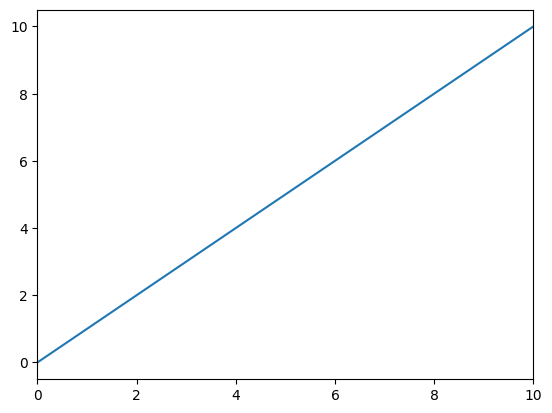

In [7]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

x = np.linspace(0, 10, 100)


def animate(t):
    plt.cla()
    plt.plot(x - t, x)
    plt.xlim(0, 10)


matplotlib.animation.FuncAnimation(fig, animate, frames=10)

In [8]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import networkx as nx

# Define the road network
G = nx.DiGraph()
G.add_edges_from([(1, 2), (2, 3), (3, 4)])
pos = {1: (0, 0), 2: (1, 1), 3: (2, 0), 4: (3, 1)}

# Define events for multiple agents
events = [
    {"agent": "A", "path": [1, 2, 3], "times": [0, 2, 4]},
    {"agent": "B", "path": [2, 3, 4], "times": [1, 3, 5]},
]

# Setup plot
fig, ax = plt.subplots()
nx.draw(G, pos, ax=ax, with_labels=True, node_color="lightblue")
agent_dots = {e["agent"]: ax.plot([], [], "o", label=e["agent"])[0] for e in events}
agent_labels = {e["agent"]: ax.text(0, 0, "", fontsize=9, ha="center") for e in events}
ax.legend()


# Animation update function
def update(frame):
    current_time = frame / 1  # assuming 10 fps
    for event in events:
        agent = event["agent"]
        times = event["times"]
        path = event["path"]
        for i in range(len(times)):
            if current_time < times[i]:
                node = path[i - 1] if i > 0 else path[0]
                x, y = pos[node]
                agent_dots[agent].set_data([x], [y])  # wrap in list
                agent_labels[agent].set_position((x, y + 0.1))
                agent_labels[agent].set_text(agent)
                break
        else:
            # After last time, stay at last node
            x, y = pos[path[-1]]
            agent_dots[agent].set_data([x], [y])
            agent_labels[agent].set_position((x, y + 0.1))
            agent_labels[agent].set_text(agent)

    return list(agent_dots.values()) + list(agent_labels.values())


ani = animation.FuncAnimation(fig, update, frames=60, interval=100, blit=True)
plt.show(

SyntaxError: incomplete input (3442162952.py, line 50)

In [ ]:
plt.show()